# Noise Modelling

Here we will look at the noise modelling - how to generate a noise model, and how to use it in training.

All noise models have certain basic characteristics:

- They take in a set of fluxes (or other features) and return noisy fluxes. If ```return_noise=True```, they also return the standard deviation of the noise applied to each flux **or an estimate thereof given the scattered flux itself**.
- They can be serialized to HDF5 files for later use, and restored from such files. This uses the ```serialize_to_hdf5``` method and the ```load_unc_model_from_hdf5``` factory function.

### Depth Noise Model

The simplest noise model is the Depth Noise Model, which adds Gaussian noise with a standard deviation determined by the depth of the observation. This takes a depth (in AB mag), and optionally a depth sigma (default 5.0), which sets the SNR at the given depth. The flux is this noise model is distributed in flux space *not* magnitude space.

If you're using this model there are a few things to keep in mind:
- If you are training in magnitude space and conditioning the model on the magnitude errors, they are not well-behaved near the detection limit, as the flux errors become non-Gaussian in magnitude space. The code uses the approximation sigma_mag = 2.5 / ln(10) * (sigma_flux / flux) to estimate the magnitude errors, but this breaks down near the detection limit, and can lead to very large or undefined magnitude errors. Negative fluxes will lead to NaN magnitude errors.


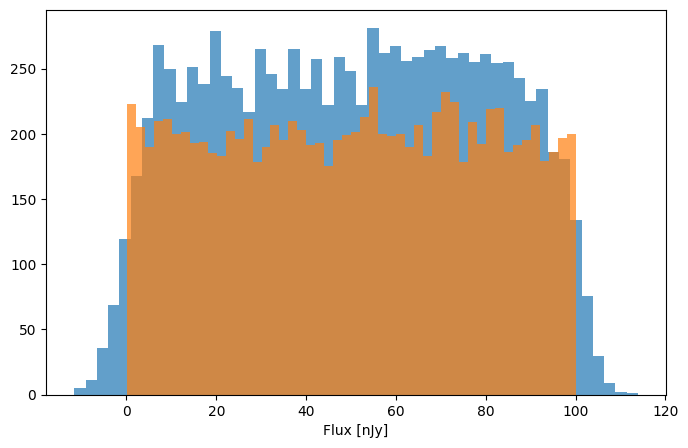

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from unyt import nJy

from synference import DepthUncertaintyModel

noise_model = DepthUncertaintyModel(depth_ab=28, return_noise=True)


fluxes = np.random.uniform(0.1, 100, size=10_000) * nJy

noisy_fluxes, sigmas = noise_model.apply_noise(fluxes, out_units=nJy)

plt.figure(figsize=(8, 5))
plt.xlabel("Flux [nJy]")
plt.hist(
    (noisy_fluxes),
    bins=50,
    density=False,
    alpha=0.7,
)

plt.hist(
    (fluxes.to_value(nJy)),
    bins=50,
    density=False,
    alpha=0.7,
);

We can set the output units as well - here we choose AB magnitudes, and plot the noisy fluxes against the true fluxes:

In [ ]:
noisy_fluxes, sigmas = noise_model.apply_noise(fluxes, out_units="AB")


plt.scatter(-2.5 * np.log10(fluxes) + 31.4, noisy_fluxes, s=1, alpha=0.5)
# plot 1:1 line
plt.plot([26, 35], [26, 35], color="red", linestyle="--")
plt.xlabel("True Magnitude [AB]")
plt.ylabel("Noisy Magnitude [AB]")

### General Noise Model

This noise model is designed to match the noise distribution of a given dataset. It fits a model to the relationship between flux and flux uncertainty in the data, and uses this to generate noisy fluxes. There are a few different ways to use this model, depending on your use case.

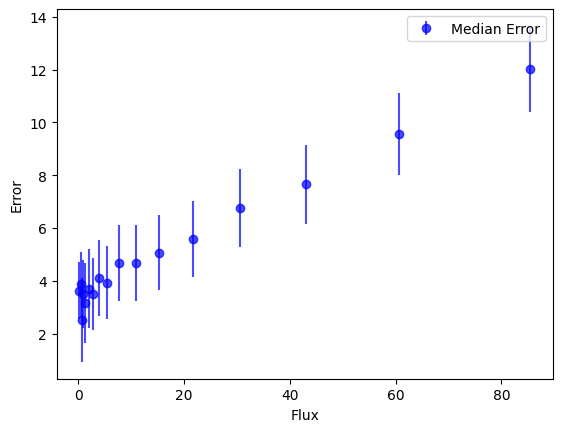

In [ ]:
from synference import GeneralEmpiricalUncertaintyModel

# Generate some fake random data with noise

# model error as a function of flux in bins
errors = 0.1 * fluxes + 1.0 * nJy + 5.0 * nJy * np.random.rand(len(fluxes))


noise_model = GeneralEmpiricalUncertaintyModel(observed_fluxes=fluxes,
                                               observed_errors=errors,
                                               flux_unit=nJy)

noise_model.plot()

### Asinh Noise Model

This noise model can also match the noise distribution of a given dataset, but uses an asinh transformation to better handle low SNR data. This is particularly useful when working with data that includes many non-detections or upper limits. The asinh transformation helps to stabilize the variance and make the noise distribution more Gaussian-like, which can improve the performance of models trained on this data.

Text(0, 0.5, 'Magnitude [asinh]')

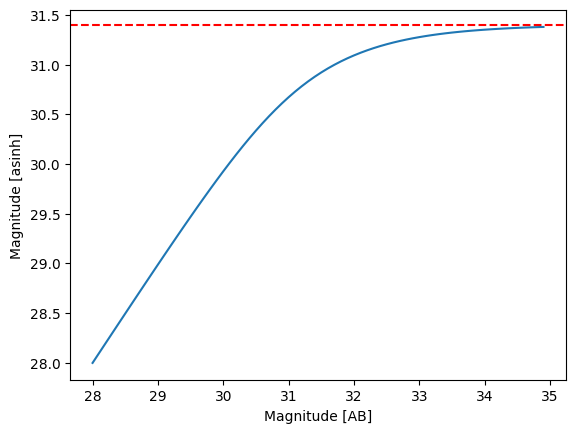

In [6]:
from synference.utils import f_jy_to_asinh

mags = np.arange(28, 35, 0.1)
fluxes = 10 ** ((mags - 31.4) / -2.5) * nJy
asinh_fluxes = f_jy_to_asinh(fluxes.to("Jy"), f_b=1 * nJy)

plt.plot(mags, asinh_fluxes)
plt.axhline(31.4, color="red", linestyle="--")
plt.xlabel("Magnitude [AB]")
plt.ylabel("Magnitude [asinh]")

This noise model is implemented in the ```AsinhEmpiricalUncertaintyModel``` class. It works similarly to the ```GeneralEmpiricalUncertaintyModel```, but applies the asinh transformation to the fluxes before fitting the noise model. It only excepts input fluxes in Jy units, and whilst the ```apply_noise``` method will accept the ```out_flux_unit``` argument for consistency with other noise models, the output fluxes will always be in asinh magnitudes.

For this model, the asinh softening parameter is not set directly, but in multiples of the median standard deviation of the flux uncertainties in the training data. This is set using the ```f_b_factor``` argument when initializing the model. For example, setting ```f_b_factor=1.0``` will set the softening parameter to the median flux uncertainty, while ```f_b_factor=2.0``` will set it to twice the median flux uncertainty. By default, ```f_b_factor=5.0```, so the softening parameter is set to five times the median flux uncertainty (aka the $5\sigma$ detection limit).

0.4199974552698413 Jy


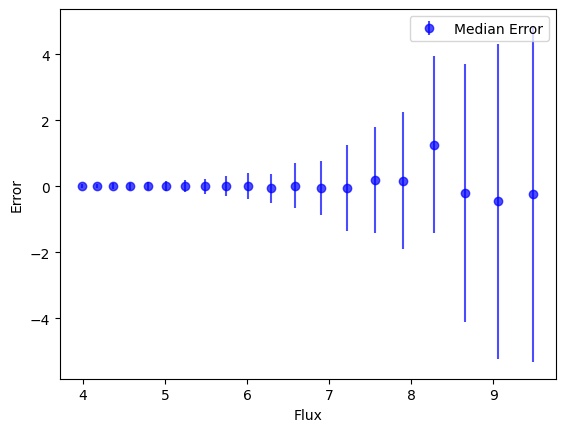

In [14]:
from synference import AsinhEmpiricalUncertaintyModel
from unyt import Jy

# Generate mock data
fluxes = np.random.uniform(0.1, 100, size=10_000) * Jy
errors = np.random.normal(0.0, 5.0, size=10_000) * Jy

noise_model = AsinhEmpiricalUncertaintyModel(observed_phot_jy=fluxes,
                                            observed_phot_errors_jy=errors,
)

print(noise_model.b)

noise_model.plot()